# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


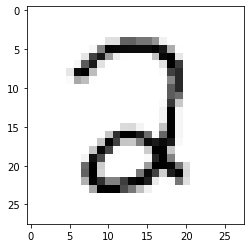

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2415
Training Accuracy: 0.5953, Testing Accuracy: 0.6104



Epoch 10, Loss 0.1291
Training Accuracy: 0.8844, Testing Accuracy: 0.8987



Epoch 20, Loss 0.0727
Training Accuracy: 0.9226, Testing Accuracy: 0.9355



Epoch 30, Loss 0.053
Training Accuracy: 0.9426, Testing Accuracy: 0.9551



Epoch 40, Loss 0.0437
Training Accuracy: 0.9514, Testing Accuracy: 0.9617



Epoch 50, Loss 0.0385
Training Accuracy: 0.9564, Testing Accuracy: 0.9632



Epoch 60, Loss 0.0352
Training Accuracy: 0.9592, Testing Accuracy: 0.9662



Epoch 70, Loss 0.0329
Training Accuracy: 0.9627, Testing Accuracy: 0.9693



Epoch 80, Loss 0.0312
Training Accuracy: 0.9643, Testing Accuracy: 0.9698



Epoch 90, Loss 0.0298
Training Accuracy: 0.9651, Testing Accuracy: 0.9703



Epoch 100, Loss 0.0286
Training Accuracy: 0.9660, Testing Accuracy: 0.9698



Epoch 110, Loss 0.0277
Training Accuracy: 0.9675, Testing Accuracy: 0.9708



Epoch 120, Loss 0.0268
Training Accuracy: 0.9684, Testing Accuracy: 0.9703



Epoch 130, Loss 0.0261
Training Accuracy: 0.9693, Testing Accuracy: 0.9713



Epoch 140, Loss 0.0254
Training Accuracy: 0.9706, Testing Accuracy: 0.9713



Epoch 150, Loss 0.0249
Training Accuracy: 0.9714, Testing Accuracy: 0.9713



Epoch 160, Loss 0.0243
Training Accuracy: 0.9720, Testing Accuracy: 0.9713



Epoch 170, Loss 0.0238
Training Accuracy: 0.9727, Testing Accuracy: 0.9723



Epoch 180, Loss 0.0233
Training Accuracy: 0.9732, Testing Accuracy: 0.9723



Epoch 190, Loss 0.0229
Training Accuracy: 0.9739, Testing Accuracy: 0.9718



Epoch 200, Loss 0.0225
Training Accuracy: 0.9746, Testing Accuracy: 0.9718



Epoch 210, Loss 0.0221
Training Accuracy: 0.9752, Testing Accuracy: 0.9723



Epoch 220, Loss 0.0217
Training Accuracy: 0.9759, Testing Accuracy: 0.9718



Epoch 230, Loss 0.0214
Training Accuracy: 0.9763, Testing Accuracy: 0.9718



Epoch 240, Loss 0.021
Training Accuracy: 0.9765, Testing Accuracy: 0.9723



0.014566658831632415

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.1986
Training Accuracy: 0.8110, Testing Accuracy: 0.8155



Epoch 10, Loss 0.0995
Training Accuracy: 0.9120, Testing Accuracy: 0.9254



Epoch 20, Loss 0.0783
Training Accuracy: 0.9274, Testing Accuracy: 0.9430



Epoch 30, Loss 0.068
Training Accuracy: 0.9359, Testing Accuracy: 0.9491



Epoch 40, Loss 0.0616
Training Accuracy: 0.9406, Testing Accuracy: 0.9516



Epoch 50, Loss 0.0572
Training Accuracy: 0.9432, Testing Accuracy: 0.9541



Epoch 60, Loss 0.054
Training Accuracy: 0.9463, Testing Accuracy: 0.9572



Epoch 70, Loss 0.0514
Training Accuracy: 0.9488, Testing Accuracy: 0.9592



Epoch 80, Loss 0.0494
Training Accuracy: 0.9504, Testing Accuracy: 0.9622



Epoch 90, Loss 0.0477
Training Accuracy: 0.9519, Testing Accuracy: 0.9632



Epoch 100, Loss 0.0463
Training Accuracy: 0.9528, Testing Accuracy: 0.9637



Epoch 110, Loss 0.0451
Training Accuracy: 0.9538, Testing Accuracy: 0.9637



Epoch 120, Loss 0.044
Training Accuracy: 0.9546, Testing Accuracy: 0.9652



Epoch 130, Loss 0.0431
Training Accuracy: 0.9563, Testing Accuracy: 0.9652



Epoch 140, Loss 0.0422
Training Accuracy: 0.9566, Testing Accuracy: 0.9657



Epoch 150, Loss 0.0415
Training Accuracy: 0.9574, Testing Accuracy: 0.9657



Epoch 160, Loss 0.0408
Training Accuracy: 0.9579, Testing Accuracy: 0.9662



Epoch 170, Loss 0.0402
Training Accuracy: 0.9579, Testing Accuracy: 0.9662



Epoch 180, Loss 0.0396
Training Accuracy: 0.9588, Testing Accuracy: 0.9667



Epoch 190, Loss 0.0391
Training Accuracy: 0.9589, Testing Accuracy: 0.9672



Epoch 200, Loss 0.0386
Training Accuracy: 0.9594, Testing Accuracy: 0.9677



Epoch 210, Loss 0.0382
Training Accuracy: 0.9599, Testing Accuracy: 0.9682



Epoch 220, Loss 0.0377
Training Accuracy: 0.9604, Testing Accuracy: 0.9682



Epoch 230, Loss 0.0374
Training Accuracy: 0.9608, Testing Accuracy: 0.9677



Epoch 240, Loss 0.037
Training Accuracy: 0.9611, Testing Accuracy: 0.9677



0.05011851162543135

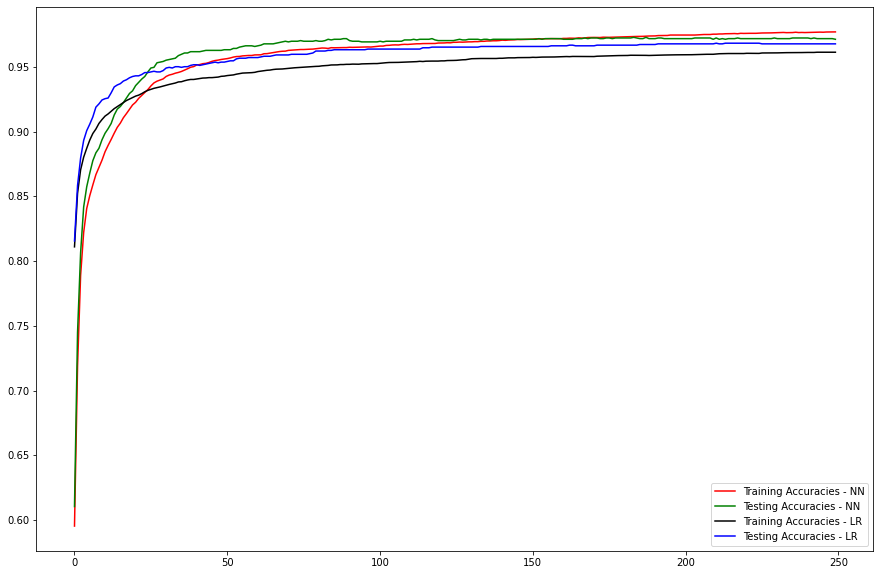

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

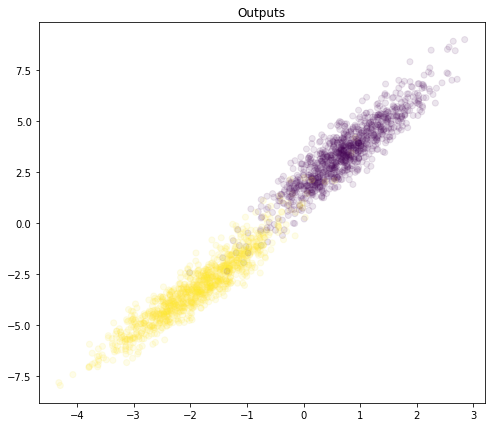

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

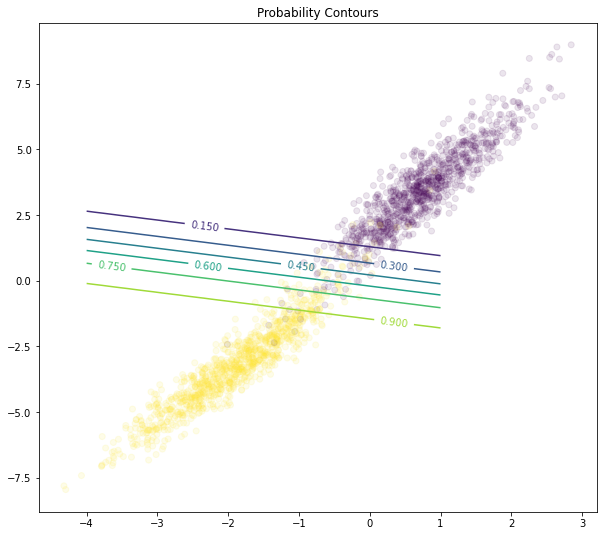

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );